Question 1

In [17]:
import jax
from matplotlib import pyplot as plt
import time

In [46]:
def get_data_generator(batchsize):
    def getbatch(key):
        key, subkey = jax.random.split(key)
        context = 10*jax.random.uniform(subkey, [batchsize])
        key, subkey = jax.random.split(key)
        output = 3 + 10 * context - 0.7 * context**2 + jax.random.normal(subkey, [batchsize])
        return context, output
    return getbatch

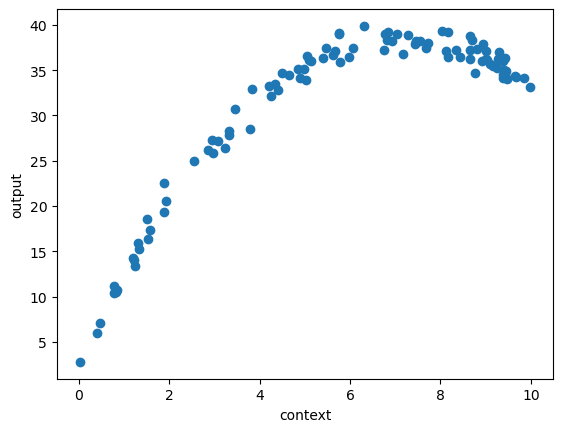

In [47]:
gen = get_data_generator(100)

key = jax.random.PRNGKey(0)
context, output = gen(key)
plt.plot(context, output, 'o')
plt.xlabel('context')
plt.ylabel('output')
plt.show()


Question 2

In [57]:
import time
import jax
from jax import flatten_util
from jax import numpy as jnp
from typing import Callable
def signed_gradient_descent(net: Callable, loss: Callable, getbatch: Callable, max_iter: int, learning_rates: list[int], *params):
    assert isinstance(net,Callable)
    assert isinstance(loss,Callable)
    assert isinstance(getbatch,Callable)
    assert isinstance(max_iter,int)

    key = jax.random.PRNGKey(0)
    w, unflatten = jax.flatten_util.ravel_pytree(params)

    # batch predictive network over context, but not params
    batched_net = jax.vmap(net,[0]+[None]*len(params))
    # batch loss over both context and predictions
    batched_loss = jax.vmap(loss)

    def l(key,w):
        params = unflatten(w)
        context, next = getbatch(key)
        pred = batched_net(context,*params)
        return jnp.mean(batched_loss(pred, next))

    fun = jax.value_and_grad(l,1)

    t0 = time.time()

    avg_grad = 0
    avg_loss = 0
    smooth_loss = 0

    print(" iter     l.r.     loss (smooth)    (avg)     time")
    print("----- -------- -------- -------- -------- --------")
   
    for i in range(max_iter):
        n = int(i * len(learning_rates) / max_iter)

        key, subkey = jax.random.split(key)
        loss, grad = fun(subkey, w)
        avg_loss = (i*avg_loss + loss)/(i+1)
        alpha = max(.01,1/(i+1))
        smooth_loss = alpha*loss + (1-alpha) * smooth_loss

        if i % (max_iter // 20) == 0:
            print(f"{i: >5} {learning_rates[n]:8.5f} {loss:8.5f} {smooth_loss:8.5f} {avg_loss:8.5f} {time.time()-t0:8.5f}")
        avg_grad = 0.9 * avg_grad + 0.1 * grad

        w = w - learning_rates[n]*jnp.sign(avg_grad)
   
    t = time.time()-t0
    t = round(t * 1000, 5)

    if len(params)==1:
        params = unflatten(w)[0]
        # print(f"  {t}   | {params[0]}  | {params[1]} | {params[2]} | {avg_loss} ")
        return params
    else:
        params = unflatten(w)
        # print(f"  {t}   | {params[0]}  | {params[1]} | {params[2]} | {avg_loss} ")
        return unflatten(w)

def net(context,a,b,c):
    return a + b*context + c*context**2

def loss(pred, output):
    return (pred - output)**2

In [ ]:
# arrays of batchsize, max_iter, learning_rates
batchsizes = [1,10,100,100,100]
max_iters = 1001
learning_rates = [[.1],[.1],[.1],[.01], [.1,.01]]

print("  Time (ms)   |       a       |      b     |       c     |   final smooth loss")
print("--------------|---------------|------------|-------------|---------------------")

for batchsize, learning_rate in zip(batchsizes, learning_rates):
    key = jax.random.PRNGKey(0)
    a = jax.random.normal(key, 1)
    b = jax.random.normal(key, 1)
    c = jax.random.normal(key, 1)
    params = [a,b,c]

    gen = get_data_generator(batchsize)
    key = jax.random.PRNGKey(0)
   
    params = signed_gradient_descent(net, loss, gen, max_iters, learning_rate, *params)
    print(f"  {params} ")

  Time (ms)   |       a       |      b     |       c     |   final smooth loss
--------------|---------------|------------|-------------|---------------------
  2605.96681   | [3.6941566]  | [7.0941534] | [-0.9058423] | 303.3845520019531 
  2494.78602   | [3.4941568]  | [9.494158] | [-0.70584226] | 66.2212905883789 
  2495.23616   | [2.6941576]  | [10.294161] | [-0.5058422] | 50.71369552612305 
  2482.02205   | [5.504189]  | [8.924267] | [-0.59584194] | 112.87616729736328 
  2494.96484   | [3.0341573]  | [10.014162] | [-0.6858425] | 31.885662078857422 


Question 3

1. It seems that smaller batch size (e.g. 1) results in slightly higher running time than bigger batch sizes (e.g. 100). Slower learning rates similarly result in slightly higher running time as well, although all are not significant changes. \
2. It seems that larger batches and slower learning rates result in better final parameters, although not entirely consistent. \
3. The final smooth loss seems to decrease with larger batchsizes. It also seems to work best with mixed learning rates, but in general, it seems that the final loss is lower with slower learning rate \

Question 4

In [22]:
chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '?', ':', '"', "'", '+', ',', '.', ' ', '\n']
start = [55, 17, 14, 70, 51, 27, 24, 19, 14, 12, 29, 70, 42, 30, 29, 14, 23,
       11, 14, 27, 16, 70, 40, 37, 24, 24, 20, 70, 24, 15, 70, 55, 17, 14,
       70, 40, 25, 18, 12, 70, 24, 15, 70, 54, 10, 30, 21, 68, 70, 11, 34,
       70, 58, 18, 21, 21, 18, 10, 22, 70, 38, 21, 14, 10, 31, 14, 27, 70,
       58, 18, 21, 20, 18, 23, 28, 24, 23]

res = ''.join([chars[c] for c in start])

print(res)

The Project Gutenberg EBook of The Epic of Saul, by William Cleaver Wilkinson


Question 5

In [23]:
import jax.numpy as jnp

In [24]:
data = jnp.load('data.npz',mmap_mode='r')['data']

In [25]:
def get_data_generator(context_size, batch_size):
    def getbatch(key):
        key, subkey = jax.random.split(key)
        start = jax.random.randint(subkey, shape=batch_size, minval=0, maxval=len(data)-context_size)
        indices = start[:,None] + jnp.arange(context_size)[None,:]
        context = data[indices] # (batchsize x context_size)
        next = data[start+context_size] # (batchsize,)
        return context, next
    return getbatch

In [26]:
key = jax.random.PRNGKey(0)
getbatch = get_data_generator(50, 5)
context, next = getbatch(key)

print("Shape of context: ", context.shape, "Shape of next: ", next.shape)

print("context: ", context)

print("next: ", next)

Shape of context:  (5, 50) Shape of next:  (5,)
context:  [[24 23 28 25 18 27 10 12 34 68 71 14 33 29 14 23 13 14 13 70 11 34 70 29
  17 14 70 36 12 29 28 70 24 15 70  1  8  8  7 68 70  1  8  9  1 68 70 10
  23 13]
 [18 29 14 13 70 54 29 10 29 14 28 70 12 24 25 34 27 18 16 17 29 70 18 23
  70 29 17 14 28 14 70 32 24 27 20 28 68 70 28 24 70 29 17 14 70 41 24 30
  23 13]
 [28 69 70 44 29 70 18 28 70 25 27 24 11 10 11 21 14 70 29 17 10 29 70 39
  30 27 17 10 22 71 32 10 28 70 27 14 10 21 21 34 70 22 24 27 14 70 18 23
  15 21]
 [23 70 29 17 14 70 56 23 18 29 14 13 70 54 29 10 29 14 28 68 70 32 14 70
  13 24 70 23 24 29 70 12 21 10 18 22 70 10 70 27 18 16 17 29 70 29 24 70
  25 27]
 [10 28 70 32 14 21 21 69 65 71 71 65 44 70 32 10 28 70 16 24 18 23 16 70
  29 24 70 10 28 20 70 34 24 30 70 29 24 70 21 14 29 70 22 14 70 29 10 20
  14 70]]
next:  [70 10 30 14 10]


a)\
context shape: (5, 50). (batchsize, context_size) \
next shape: (5,) (batchsize) \

b)
context contains the batched numerical data that act as the input ("previous knowledge") to predict the target values contained in next. \

c)
the key is split into 2 subkeys, one for the context and one for next, such that we dont reuse the same random variables when generating.





question 6

In [27]:
from jax.nn import logsumexp

def loss(pred,next):
    num_characters = len(chars)
    assert pred.shape == (num_characters,)
    assert next.shape == ()
    log_probs = pred - logsumexp(pred)
    assert log_probs.shape == (num_characters,)
    next_onehot = jax.nn.one_hot(next, num_classes=num_characters)
    assert next_onehot.shape == (num_characters,)
    out = -jnp.sum(log_probs * next_onehot)
    assert out.shape == ()
    return out

    

In [28]:
def constant_net(context, b):
    # input context is a 1-D array of size context_size
    # each entry is an index between 0 and num_characters
    # these represent the most recent characters
    (context_size,) = context.shape
    (num_characters,) = b.shape

    # [do stuff.]

    # predict a constant vector
    pred = b

          
    assert pred.shape == (num_characters,)
    return pred

In [ ]:
batchsize = 4096
context_size = 32
iters = 10000
learning_rates = [.001, .0001]
b = jnp.zeros(len(chars))

params = [b]

gen = get_data_generator(context_size, batchsize)

params = signed_gradient_descent(constant_net, loss, gen, iters, learning_rates, *params)



 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.00100  4.27667  4.27667  4.27667  0.02772
  500  0.00100  3.75796  3.84823  4.00168  2.72620
 1000  0.00100  3.42981  3.48416  3.79038  5.43914
 1500  0.00100  3.28311  3.28676  3.63863  8.39022
 2000  0.00100  3.18296  3.18663  3.53152 11.02354
 2500  0.00100  3.13428  3.14404  3.45595 13.64159
 3000  0.00100  3.13118  3.13523  3.40261 16.30306
 3500  0.00100  3.14047  3.13310  3.36422 19.26403
 4000  0.00100  3.10767  3.13320  3.33532 21.99465
 4500  0.00100  3.11254  3.13212  3.31281 24.82710
 5000  0.00010  3.12061  3.13259  3.29482 27.55235
 5500  0.00010  3.11545  3.13263  3.28018 30.22116
 6000  0.00010  3.14931  3.13334  3.26787 33.03475
 6500  0.00010  3.15036  3.13409  3.25748 35.96461
 7000  0.00010  3.14825  3.13339  3.24855 38.84472
 7500  0.00010  3.11208  3.13300  3.24085 41.47183
 8000  0.00010  3.14472  3.13200  3.23414 44.18035
 8500  0.00010  3.11545  3.1345

Question 7

In [30]:
char2int = dict(zip(chars, range(len(chars))))

def generate_char(net,context,key,*params):
    pred = net(context,*params);
    assert pred.shape == (num_characters,)
    out = jax.random.categorical(key, pred);
    assert out.shape == ()
    return out

def generate(net,context_str,context_size,num_char,*params):
    context = [char2int[c] for c in context_str]

    key = jax.random.PRNGKey(1)
    for i in range(num_char):
        key, subkey = jax.random.split(key)
        my_context = jnp.array(context[-context_size:])
        c = generate_char(net,my_context,subkey,*params)
        context.append(int(c))

    out = ''.join([chars[i] for i in context])

    return out

In [31]:
b_constant = params
start = "STUDENT:\nI have searched the skies and found...\n\nTEACHER:\nYes? What have you found?\n\nSTUDENT\nI have found a fact, a fact most excellent.\n"
num_characters = len(chars)
print(generate(constant_net,start,context_size,500,b_constant))

STUDENT:
I have searched the skies and found...

TEACHER:
Yes? What have you found?

STUDENT
I have found a fact, a fact most excellent.
  c rtttu
 e e
lv ib,grunek  el iertah d
  pauo goghmf e  lrC"ac  ty
eb tte  biic,nitn iohp
oooiotttracvenn   ern..ch I uen th ee
ha alelr   woteInupo t  r w
ro"e.lr
b ubDepegyttloi.hsinnceOfimtwd
wc,ernreluebn tnl dpcer sis  ds reo "doh a ne c.satsfnm lsa rnf rioefhaorcodees heotG e ao
ohtle dmhe  eC ecsd2c,aride  eei Th?ordr
Paehaeel l ud 0hrsoiad e eiavewi mr
dtf   s fyahiSs eIn p oic olo
 d r a Re mmth r leSess dto seiia  ielmrt hedluii2e s 
liy ,frocn
  fmce g dBndctud .iod ,agty  l .L shEp


Question 8

In [32]:
import numpy as np

In [33]:
def linear_net(context, b, W):
    # W, b = params[0], params[1]
    # print('w: ', W)
    # print('b: ', b)

    (context_size,) = context.shape

    (context_size2, num_characters, num_characters2) = W.shape
    assert context_size == context_size2
    assert num_characters == num_characters2

    context_onehot = jax.nn.one_hot(context, num_classes=num_characters)
    assert context_onehot.shape == (context_size, num_characters)


    # We need to multiply context_onehot with W along the context_size dimension
    
    pred = jnp.einsum('ij,ijk->k', context_onehot, W) + b

    assert pred.shape == (num_characters,)
    return pred

In [34]:
batchsize = 4096
context_size = 32
iters = 10000
learning_rates = [.001, .0001]
num_characters = len(chars)

b_linear = jnp.zeros(num_characters)
W_linear = jnp.array(.01*np.random.randn(context_size, num_characters, num_characters))


params = [b_linear, W_linear]

gen = get_data_generator(context_size, batchsize)

params = signed_gradient_descent(linear_net, loss, gen, iters, learning_rates, *params)

 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.00100  4.28394  4.28394  4.28394  0.16214
  500  0.00100  2.56146  2.63390  2.84003  7.86799
 1000  0.00100  2.37643  2.39678  2.64487 15.21716
 1500  0.00100  2.33781  2.31454  2.54092 22.31885
 2000  0.00100  2.29808  2.28205  2.47820 29.77769
 2500  0.00100  2.26396  2.27183  2.43770 37.18627
 3000  0.00100  2.28718  2.27311  2.41000 44.95227
 3500  0.00100  2.24690  2.27569  2.39074 52.18431
 4000  0.00100  2.29151  2.28119  2.37678 59.62810
 4500  0.00100  2.28138  2.28403  2.36655 67.86923
 5000  0.00010  2.28246  2.29063  2.35896 75.23881
 5500  0.00010  2.30287  2.28773  2.35269 83.16335
 6000  0.00010  2.29197  2.28485  2.34715 93.40257
 6500  0.00010  2.35776  2.28828  2.34241 106.17691
 7000  0.00010  2.31598  2.28488  2.33819 114.35264
 7500  0.00010  2.24745  2.28746  2.33473 125.59524
 8000  0.00010  2.26777  2.28614  2.33171 135.56565
 8500  0.00010  2.27731  2.

Question 9

In [35]:

p = params
start = "STUDENT:\nI have searched the skies and found...\n\nTEACHER:\nYes? What have you found?\n\nSTUDENT\nI have found a fact, a fact most excellent.\n"

print(generate(linear_net,start,context_size,500, *p))

STUDENT:
I have searched the skies and found...

TEACHER:
Yes? What have you found?

STUDENT
I have found a fact, a fact most excellent.

 of the   s bllige the Amby whe probe d
 "Prup of hmuthare thacllay
d were  or canit the pestory: "Arcutwa cherragr at tenginee,
Ithale, as woted upolt  haverobe.


N CLDecaly tiol. Sin centim, of caringelleby tho dpaknes somes aiof dof aree cosstichm ls orne tion anorsedens he ther ablotele! meer ond cow ton ine beem The rom
Painatel ufuthengsoind coniag witho
d mante foreple ton proflyono
Mack are, mather theessadlougenin sizemethind uinne s inis ffrocher fice of
Bricturn. He tasty he wall be


Question 10

In [ ]:
def mlp_net(context, b, c, W, V):
    assert context.shape == (context_size,)
    (context_size,) = context.shape
    (num_characters,) = b.shape
    (num_hidden,) = c.shape
    (num_characters, num_hidden) = W.shape
    (context_size, num_characters, num_hidden) = V.shape

    context_onehot = jax.nn.one_hot(context, num_classes=num_characters)
    assert context_onehot.shape == (context_size, num_characters)

    # [do stuff]

    # first layer
    h1 = jnp.einsum('ij,ijk->k', context_onehot, V) + c
    l1 = jax.nn.relu(h1)
    

    pred = b + W @ l1
    assert pred.shape == (num_characters,)
    return pred

In [37]:
batchsize = 4096
context_size = 32
iters = 10000
learning_rates = [.001, .0001]
num_characters = len(chars)

num_hidden = 500
b_mlp = jnp.zeros(num_characters)
c_mlp = jnp.zeros(num_hidden)
W_mlp = jnp.array(.01*np.random.randn(num_characters, num_hidden))
V_mlp = jnp.array(.01*np.random.randn(context_size, num_characters, num_hidden))


params = [b_mlp, c_mlp, W_mlp, V_mlp]

gen = get_data_generator(context_size, batchsize)

params = signed_gradient_descent(mlp_net, loss, gen, iters, learning_rates, *params)

 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.00100  4.27603  4.27603  4.27603  0.79735
  500  0.00100  1.90563  2.00908  2.30095 34.99069
 1000  0.00100  1.78632  1.80122  2.06997 71.84578
 1500  0.00100  1.74954  1.73723  1.96433 112.49686
 2000  0.00100  1.74241  1.70301  1.90110 156.91322
 2500  0.00100  1.62852  1.67725  1.85782 194.31828
 3000  0.00100  1.66574  1.65953  1.82540 233.58647
 3500  0.00100  1.65879  1.64913  1.80061 270.97481
 4000  0.00100  1.63123  1.64054  1.78076 310.07613
 4500  0.00100  1.58940  1.62880  1.76425 349.32883
 5000  0.00010  1.62587  1.62300  1.75032 386.42197
 5500  0.00010  1.64957  1.59733  1.73701 425.49937
 6000  0.00010  1.61687  1.58785  1.72477 463.36210
 6500  0.00010  1.62156  1.58363  1.71394 499.46647
 7000  0.00010  1.58306  1.57478  1.70408 538.08612
 7500  0.00010  1.52659  1.57148  1.69539 577.97836
 8000  0.00010  1.56541  1.56741  1.68757 614.37243
 8500  0.00010  1

Question 11

In [38]:
p = params
start = "STUDENT:\nI have searched the skies and found...\n\nTEACHER:\nYes? What have you found?\n\nSTUDENT\nI have found a fact, a fact most excellent.\n"

print(generate(mlp_net,start,context_size,500, *p))

STUDENT:
I have searched the skies and found...

TEACHER:
Yes? What have you found?

STUDENT
I have found a fact, a fact most excellent.

To retture    liver, restor elexpress delierso of the Daymarce! The
difficulting, it will how to the cuttains one. Wat feeling mark, took the Vedaup on a swork at leagure which it grain confided two,
the lutby that parts, successed by
him he cousts of liverning obland convested the family were began anced boaring being to rell and and leud andsomal conicient of
the Volvania, satingphanced of discard, mather leters who said, as immorded upon the
like, by heart clught becauded. The stock fastshop


Question 12

In [39]:
def dbl_net(context, b, c, d, W, V, U):
    assert context.shape == (context_size,)

    context_onehot = jax.nn.one_hot(context, num_classes=num_characters)
    assert context_onehot.shape == (context_size, num_characters)

    # [do stuff]
    h1 = jnp.einsum('ijk,ij->k', V, context_onehot) + c
    l1 = jax.nn.relu(h1)
    
    # second layer
    h2 = jnp.einsum('k,jk->k', l1, U) + d
    l2 = jax.nn.relu(h2)

    pred = b + W @ l2
    assert pred.shape == (num_characters,)

    return pred

In [40]:
batchsize = 4096
context_size = 32
iters = 10000
learning_rates = [.001, .0001]
num_characters = len(chars)

num_hidden = 500
b_dbl = jnp.zeros(num_characters)
c_dbl = jnp.zeros(num_hidden)
d_dbl = jnp.zeros(num_hidden)
W_dbl = jnp.zeros((num_characters, num_hidden))
V_dbl = jnp.array(.01*np.random.randn(context_size, num_characters, num_hidden))
U_dbl = jnp.array(.01*np.random.randn(num_hidden, num_hidden))

params = [b_dbl, c_dbl, d_dbl, W_dbl, V_dbl, U_dbl]

gen = get_data_generator(context_size, batchsize)

params = signed_gradient_descent(dbl_net, loss, gen, iters, learning_rates, *params)

 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.00100  4.27667  4.27667  4.27667  0.39515
  500  0.00100  1.91986  1.98242  2.21543 52.13944
 1000  0.00100  1.84668  1.86097  2.04942 102.83609
 1500  0.00100  1.85455  1.82285  1.97715 152.54611
 2000  0.00100  1.82844  1.80457  1.93525 202.87642
 2500  0.00100  1.76737  1.79316  1.90756 253.00644
 3000  0.00100  1.77197  1.78332  1.88719 306.35678
 3500  0.00100  1.78004  1.78175  1.87214 356.96288
 4000  0.00100  1.76319  1.77826  1.86052 407.42856
 4500  0.00100  1.74391  1.77386  1.85109 456.78786
 5000  0.00010  1.76011  1.77274  1.84338 504.86405
 5500  0.00010  1.76384  1.72043  1.83286 554.39541
 6000  0.00010  1.74332  1.71038  1.82284 601.72159
 6500  0.00010  1.74147  1.70693  1.81395 649.82745
 7000  0.00010  1.72367  1.69977  1.80580 700.99020
 7500  0.00010  1.64946  1.69591  1.79862 751.55216
 8000  0.00010  1.67967  1.69293  1.79215 804.38640
 8500  0.00010  

Question 13

In [41]:

p = params
start = "STUDENT:\nI have searched the skies and found...\n\nTEACHER:\nYes? What have you found?\n\nSTUDENT\nI have found a fact, a fact most excellent.\n"

print(generate(dbl_net,start,context_size,500, *p))

STUDENT:
I have searched the skies and found...

TEACHER:
Yes? What have you found?

STUDENT
I have found a fact, a fact most excellent.

To rettle s breation oundral, for the deticalong gome that Came bar
But Jew Timc, it with and to the cuncuess on. You duen the mark, though world upon a way
rountly bevered by thod."

"He word,work at the Cebjects Rock, with discendiders
where.

 Scrusist ruserious arroodeds here was overwanted a both cown't wite been breard'
    One in where so, I canifus into
dufter Royaging to pastic plopt they be maintailed scant, such found other to him stilike, by he had lightened up of detage man which
p


Question 14

In [43]:
batchsize = 4096
context_size = 32
iters = 10000
learning_rates = [.001, .0001]
num_characters = len(chars)

num_hidden = 2500
b_dbl = jnp.zeros(num_characters)
c_dbl = jnp.zeros(num_hidden)
d_dbl = jnp.zeros(num_hidden)
W_dbl = jnp.zeros((num_characters, num_hidden))
V_dbl = jnp.array(.01*np.random.randn(context_size, num_characters, num_hidden))
U_dbl = jnp.array(.01*np.random.randn(num_hidden, num_hidden))


params = [b_dbl, c_dbl, d_dbl, W_dbl, V_dbl, U_dbl]

gen = get_data_generator(context_size, batchsize)

params = signed_gradient_descent(dbl_net, loss, gen, iters, learning_rates, *params)

 iter     l.r.     loss (smooth)    (avg)     time
----- -------- -------- -------- -------- --------
    0  0.00100  4.27667  4.27667  4.27667  0.53196
  500  0.00100  1.95496  2.00869  2.18941 231.11978
 1000  0.00100  1.90694  1.91072  2.06173 479.21931
 1500  0.00100  1.92144  1.90963  2.01003 728.60522
 2000  0.00100  1.89641  1.87344  1.97817 972.28603
 2500  0.00100  1.83292  1.86724  1.95542 1235.81153
 3000  0.00100  1.85139  1.85567  1.93868 1502.43324
 3500  0.00100  1.86184  1.85394  1.92677 1766.35529
 4000  0.00100  1.85162  1.86234  1.91908 2033.64448
 4500  0.00100  1.80985  1.87569  1.91336 2294.00349
 5000  0.00010  1.84876  1.86237  1.90806 2556.69526
 5500  0.00010  1.82357  1.78007  1.89734 2820.77900
 6000  0.00010  1.79365  1.76830  1.88672 3096.17514
 6500  0.00010  1.79828  1.76144  1.87713 3365.67538
 7000  0.00010  1.76979  1.75612  1.86842 3650.80706
 7500  0.00010  1.71450  1.75216  1.86071 3917.23336
 8000  0.00010  1.72298  1.74601  1.85365 4184.19163
 85

Question 15

In [44]:

p = params
start = "STUDENT:\nI have searched the skies and found...\n\nTEACHER:\nYes? What have you found?\n\nSTUDENT\nI have found a fact, a fact most excellent.\n"

print(generate(dbl_net,start,context_size,500, *p))

STUDENT:
I have searched the skies and found...

TEACHER:
Yes? What have you found?

STUDENT
I have found a fact, a fact most excellent.

The they we bwlitied to the slexervicil
    No goghmen. We Ccame by the Jew bish, it his passon to the know serval hak benother,
have elrast other polit way robe. Befoue
boways ind."335 Oblowers," carred lief "And Rpcers, sumpassed the barness.

 Scrust!" And the fairrs Mrss herood for beale on the Caprod William He may Mord'
Pheianes leuded thou will if still sonfented angios to pastic of the Charless the readess who sevent in mull had in ploy
like, bove o't clugidenchaud mind togeth was, shop
